In [1]:
import os
import sys

USER = os.environ.get("USER")
sys.path.append(f"/home/{USER}/anaconda3/lib/python3.7/site-packages")

In [2]:
import gc
import warnings
import datetime
import collections
from itertools import permutations

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import nimfa

np.random.seed(42)
pd.set_option('display.max_columns', 50)
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def clean_up(obj):
    del obj
    gc.collect()

In [4]:
# load in data
train = pd.read_csv('./input/train.csv', parse_dates=['first_active_month'])
test = pd.read_csv('./input/test.csv', parse_dates=['first_active_month'])
historical_transactions = pd.read_csv('./input/historical_transactions.csv', parse_dates=['purchase_date'])
new_transactions = pd.read_csv('./input/new_merchant_transactions.csv', parse_dates=['purchase_date'])

target = train['target']
train.drop("target", axis=1, inplace=True)

# Reversing the purchase amount feature back to original scale. 
# https://www.kaggle.com/raddar/towards-de-anonymizing-the-data-some-insights
historical_transactions['purchase_amount'] = np.round(historical_transactions['purchase_amount'] / 0.00150265118 + 497.06, 2)
new_transactions['purchase_amount'] = np.round(new_transactions['purchase_amount'] / 0.00150265118 + 497.06, 2)

In [5]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-06-01,C_ID_92a2005557,5,2,1
1,2017-01-01,C_ID_3d0044924f,4,1,0
2,2016-08-01,C_ID_d639edf6cd,2,2,0
3,2017-09-01,C_ID_186d6a6901,4,3,0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0


In [6]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,29.00,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,9.17,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,17.65,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,7.69,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,16.00,2017-03-10 01:14:19,1.0,16,37


In [7]:
def merge_generated_features(df_list):
    global train, test
    for df in df_list:
        train = train.merge(df, on='card_id', how='left')
        test = test.merge(df, on='card_id', how='left')

### Extract time trend in purchase patterns by purchase_month.

In [8]:
# 前回は月ごとのpurchase_amount_{sum, count, mean}に対してNMFして特徴抽出してたみたい

def compute_time_trend_in_purchases(agg_method):
    # compute min/max/mean/diff-min/diff-max/diff-mean per period
    
    periods = {
        "p1": ["-13", "-12", "-11", "-10"],
        "p2": ["-9", "-8", "-7", "-6"],
        "p3": ["-5", "-4", "-3"],
        "p4": ["-2", "-1", "0"],
    }
    
    calc_method = ["min", "max", "mean", "diff_min", "diff_max", "diff_mean"]
    
    agg_df = historical_transactions[['card_id','merchant_category_id', 'month_lag', 'purchase_amount']] \
                .groupby(['card_id', 'month_lag']) \
                .agg({'purchase_amount': [agg_method]})
    
    agg_df.columns = [f"purchase_amount_{agg_method}"]
    agg_df = agg_df.unstack().fillna(0)
    cols = agg_df.columns
    agg_df.columns = ["_".join(list(map(str, cols[i]))) for i in range(14)]
    
    use_cols = []
    for p in periods:
        for m in calc_method:
            if m == "min":
                agg_df[f"purchase_amount_{agg_method}_{m}_{p}"] = agg_df[[f"purchase_amount_{agg_method}_{i}" for i in periods[p]]] \
                                                                    .min(axis=1)
            if m == "max":
                agg_df[f"purchase_amount_{agg_method}_{m}_{p}"] = agg_df[[f"purchase_amount_{agg_method}_{i}" for i in periods[p]]] \
                                                                    .max(axis=1)
            if m == "mean":
                agg_df[f"purchase_amount_{agg_method}_{m}_{p}"] = agg_df[[f"purchase_amount_{agg_method}_{i}" for i in periods[p]]] \
                                                                    .mean(axis=1)
            if "diff" in m:
                tmp = pd.DataFrame()
                len_periods = len(periods[p])
                while len_periods > 1:
                    tmp[f"diff_{len_periods}"] = agg_df[f"purchase_amount_{agg_method}_{periods[p][len_periods-1]}"] - agg_df[f"purchase_amount_{agg_method}_{periods[p][len_periods-2]}"]
                    len_periods -= 1
                if "min" in m:
                    agg_df[f"purchase_amount_{agg_method}_{m}_{p}"] = tmp.min(axis=1)
                if "max" in m:
                    agg_df[f"purchase_amount_{agg_method}_{m}_{p}"] = tmp.max(axis=1)
                if "mean" in m:
                    agg_df[f"purchase_amount_{agg_method}_{m}_{p}"] = tmp.mean(axis=1)
                        
            use_cols.append(f"purchase_amount_{agg_method}_{m}_{p}")
    agg_df.reset_index(drop=False, inplace=True)
    return agg_df[["card_id"] + use_cols]

In [9]:
agg_methods = ["count", "sum", "mean"]
generated_dfs = [compute_time_trend_in_purchases(m) for m in agg_methods]
merge_generated_features(generated_dfs)
clean_up(generated_dfs)

### Extract user's preferences by applying NMF to user-merchant_category matrix.

In [10]:
def compute_user_preferences(agg_method):
    agg_df = historical_transactions[['card_id','merchant_category_id', 'month_lag', 'purchase_amount']] \
                .groupby(['card_id', 'merchant_category_id']) \
                .agg({'purchase_amount': [agg_method]})
    
    agg_df.columns = [f"purchase_amount_{agg_method}"]
    agg_df = agg_df.unstack().fillna(0)

    nmf = nimfa.Nmf(agg_df.values, seed='nndsvd', max_iter=30, rank=20, update='euclidean', objective='fro')
    nmf_fit = nmf()
    nmf_feats = nmf_fit.basis()
    nmf_feats = pd.DataFrame(nmf_feats)
    nmf_feats.columns = [f'nmf_merch_cate_{agg_method}_'+str(i) for i in range(1, 21)]
    nmf_feats["card_id"] = agg_df.index
    return nmf_feats

In [11]:
agg_methods = ["count", "sum", "mean"]
generated_dfs = [compute_user_preferences(m) for m in agg_methods]
merge_generated_features(generated_dfs)
clean_up(generated_dfs)

### Calculate entropy for merchant_id. This value will get smaller as a card_id makes repeated purchases at the same merchants.

### Calculate the ratio of merchants that a card_id made purchases only once.

In [12]:
# normalize by the purchase_counts(which was better than normalizing by number of unique merchants)
def norm_entropy(vec):
    entropys = list()
    count = collections.Counter(vec)
    countall = float(np.sum(np.array(list(count.values()))))
    for item in count.items():
        counteach = item[1]
        prob = counteach / countall
        entropyeach = -prob * np.log(prob)
        norm_entropy = entropyeach / len(vec)
        entropys.append(norm_entropy)
    entropy = np.sum(entropys)
    return entropy


def only_once_ratio(vec):
    count = collections.Counter(vec)
    arr = np.array(list(count.values()))
    countall = len(arr)
    only_once = len(arr[arr==1])
    only_once_ratio = only_once / countall
    return only_once_ratio


def compute_merchant_id_features():
    grp = historical_transactions.groupby('card_id')

    entropy_list = []
    ratio_list = []
    for grp_name, grp_idx in grp.groups.items():
        tmp = historical_transactions.loc[grp_idx, 'merchant_id']
        e = norm_entropy(tmp)
        entropy_list.append(e)
        
        r = only_once_ratio(tmp)
        ratio_list.append(r)

    merchant_id_features = pd.DataFrame()
    merchant_id_features['card_id'] = [i for i in grp.groups]
    merchant_id_features['merchant_id_entropy'] = entropy_list
    merchant_id_features['only_once_merchant_ratio'] = ratio_list

    return merchant_id_features

In [13]:
generated_dfs = [compute_merchant_id_features()]
merge_generated_features(generated_dfs)
clean_up(generated_dfs)

### Inpute missing values with mode. (better score)

In [14]:
for df in [historical_transactions, new_transactions]:
    df['category_3'].fillna('A', inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)
    df['category_2'].fillna(1.0, inplace=True)

### Calculate the gaps between purchase_dates for each card_id. Aggregate later.

In [15]:
def compute_purchase_frequencies():
    time_delta_df = historical_transactions.sort_values(['card_id', 'purchase_date'])[['card_id', 'purchase_date']].reset_index(drop=True)
    time_delta_df['time_since_last_purchase'] = 0

    before_id = None
    zero_points = []
    for i, id_ in tqdm(time_delta_df["card_id"].iteritems()):
        if id_ != before_id:
            zero_points.append(i)
            before_id = id_
    
    time_delta_df.loc[:,"time_since_last_purchase"] = time_delta_df.loc[:,"purchase_date"].diff()
    time_delta_df.loc[zero_points,"time_since_last_purchase"] = pd.Timedelta(0)

    time_delta_df['time_since_last_purchase'] = time_delta_df['time_since_last_purchase'].astype(int) * 10**(-9)
    time_delta_df = time_delta_df.groupby('card_id').agg({'time_since_last_purchase':['mean', 'var', 'max']})
    time_delta_df.columns = ['_'.join(col) for col in time_delta_df.columns.values]
    time_delta_df.reset_index(inplace=True)
    return time_delta_df

In [16]:
generated_dfs = [compute_purchase_frequencies()]
merge_generated_features(generated_dfs)
clean_up(generated_dfs)

29112361it [00:06, 4758238.12it/s]


### Add sum of purchase counts per category in histrical transactions.

In [17]:
def compute_sum_purchase_counts():
    top100_category = historical_transactions['merchant_category_id'].value_counts()[:100].keys()

    historical_transactions['top100'] = historical_transactions['merchant_category_id'].apply(lambda x: 1 if x in top100_category else 0)
    top100_historical_transactions = historical_transactions[historical_transactions['top100'] == 1][['card_id', 'merchant_category_id']]
    top100_historical_transactions = pd.get_dummies(top100_historical_transactions, columns=['merchant_category_id'])

    df_sum = top100_historical_transactions[['card_id', 'merchant_category_id_2']].groupby('card_id').sum()
    cols = list(top100_historical_transactions.columns.values)[2:]

    for col in tqdm(cols):
        df_sum[col] = top100_historical_transactions[['card_id', col]].groupby('card_id').sum()
        del top100_historical_transactions[col]
        gc.collect()
        
    df_sum.reset_index(inplace=True)
    return df_sum

In [18]:
generated_dfs = [compute_sum_purchase_counts()]
merge_generated_features(generated_dfs)
clean_up(generated_dfs)

100%|██████████| 99/99 [03:22<00:00,  2.05s/it]


### Same for new transactions.

In [19]:
def compute_sum_purchase_counts_new():
    tmp = new_transactions[['card_id', 'merchant_category_id']]
    specific_cate_ids = tmp[(tmp['merchant_category_id'] == 755) |
                            (tmp['merchant_category_id'] == 511) |
                            (tmp['merchant_category_id'] == 451)]
    specific_cate_ids.reset_index(inplace=True, drop=True)
    specific_cate_ids = pd.get_dummies(specific_cate_ids, columns=['merchant_category_id'])
    df_sum_new = specific_cate_ids.groupby('card_id').sum()
    df_sum_new.columns = ['new_' + col for col in df_sum_new.columns]
    df_sum_new.reset_index(inplace=True)
    
    return df_sum_new

In [20]:
generated_dfs = [compute_sum_purchase_counts_new()]
merge_generated_features(generated_dfs)
clean_up(generated_dfs)

### Extract some other time-related features and also some preprocessing.

In [21]:
def preprocess_time_related_features_in_transactions(df):
    #time related feature from purchase date
    df['purchase_year'] = df['purchase_date'].dt.year
    df['purchase_weekofyear'] = df['purchase_date'].dt.weekofyear
    df['purchase_month'] = df['purchase_date'].dt.month
    df['purchase_dayofweek'] = df['purchase_date'].dt.dayofweek
    df['purchase_weekend'] = (df['purchase_dayofweek'] >=5).astype(int)
    df['purchase_hour'] = df['purchase_date'].dt.hour
   
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    
    df['month_diff'] = ((datetime.datetime(2018, 12, 27) - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    df['purchase_date_int'] = pd.DatetimeIndex(df['purchase_date']).astype(np.int64) * 1e-9
    return pd.get_dummies(df, columns=['month_lag'])

In [22]:
historical_transactions = preprocess_time_related_features_in_transactions(historical_transactions)
new_transactions = preprocess_time_related_features_in_transactions(new_transactions)

### Aggregate numerical features from transactions. 

In [23]:
def aggregate_hist_transactions(df):
    
    aggs = {
        'card_id': ['size'], #transaction_count
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'max', 'min', 'mean', 'var'],
        'installments': ['sum', 'max', 'min', 'mean', 'var'],
        'purchase_year': ['nunique'],
        'purchase_month': ['nunique'],
        'purchase_hour': ['nunique'],
        'purchase_weekofyear': ['nunique'],
        'purchase_dayofweek': ['nunique'],
        'purchase_date': ['min', 'max'],
        'purchase_date_int':['var'],
        'purchase_weekend': ['sum', 'mean'],
        'month_diff': ['mean', 'var'],
        'month_lag_-13': ['mean','sum'], 
        'month_lag_-12': ['mean','sum'], 
        'month_lag_-11': ['mean','sum'], 
        'month_lag_-10': ['mean','sum'], 
        'month_lag_-9': ['mean','sum'], 
        'month_lag_-8': ['mean','sum'], 
        'month_lag_-7': ['mean','sum'], 
        'month_lag_-6': ['mean','sum'], 
        'month_lag_-5': ['mean','sum'], 
        'month_lag_-4': ['mean','sum'], 
        'month_lag_-3': ['mean','sum'], 
        'month_lag_-2': ['mean','sum'], 
        'month_lag_-1': ['mean','sum'], 
        'month_lag_0': ['mean','sum']
        }
    
    for col in ['category_2','category_3']:
        df[col+'_mean'] = df.groupby([col])['purchase_amount'].transform('mean')
        aggs[col+'_mean'] = ['mean']
        
    
    agg_df = df.groupby(['card_id']).agg(aggs)
    agg_df.columns = ['_'.join(col) for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    return agg_df

In [24]:
def aggregate_new_transactions(df):
    
    aggs = {
        'card_id': ['size'], #transaction_count
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'max', 'min', 'mean', 'var'],
        'installments': ['sum', 'max', 'min', 'mean', 'var'],
        'purchase_year': ['nunique'],
        'purchase_month': ['nunique'],
        'purchase_hour': ['nunique'],
        'purchase_weekofyear': ['nunique'],
        'purchase_dayofweek': ['nunique'],
        'purchase_date': ['min', 'max'],
        'purchase_date_int':['var'],
        'purchase_weekend': ['sum', 'mean'],
        'month_diff': ['mean', 'var'],
        'month_lag_2': ['mean','sum'], 
        'month_lag_1': ['mean','sum']
        }
    
    for col in ['category_2','category_3']:
        df[col+'_mean'] = df.groupby([col])['purchase_amount'].transform('mean')
        aggs[col+'_mean'] = ['mean']
        
    
    agg_df = df.groupby(['card_id']).agg(aggs)
    agg_df.columns = ['_'.join(col) for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    return agg_df

In [25]:
historical = aggregate_hist_transactions(historical_transactions)
historical.columns = ['hist_' + c if c != 'card_id' else c for c in historical.columns]

new = aggregate_new_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]

In [26]:
#some more features using aggregated features

historical['hist_purchase_date_diff'] = (historical['hist_purchase_date_max'] - historical['hist_purchase_date_min']).dt.days
historical['hist_purchase_date_average'] = historical['hist_purchase_date_diff'] / historical['hist_card_id_size']
historical['hist_purchase_date_uptonow'] = (datetime.datetime(2018, 12, 27) - historical['hist_purchase_date_max']).dt.days

new['new_purchase_date_diff'] = (new['new_purchase_date_max'] - new['new_purchase_date_min']).dt.days
new['new_purchase_date_average'] = new['new_purchase_date_diff'] / new['new_card_id_size']
new['new_purchase_date_uptonow'] = (datetime.datetime(2018, 12, 27) - new['new_purchase_date_max']).dt.days

In [27]:
generated_dfs = [historical, new]
merge_generated_features(generated_dfs)
clean_up(generated_dfs)

### Add some features in train/test.

In [28]:
def add_more_features(df):
    # df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['first_dayofweek'] = df['first_active_month'].dt.dayofweek
    df['first_weekofyear'] = df['first_active_month'].dt.weekofyear
    df['first_month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max', 'hist_purchase_date_min', 'new_purchase_date_max', 'new_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_card_id_size'] + df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_purchase_amount_sum'] + df['hist_purchase_amount_sum']

In [29]:
for df in [train, test]:
    add_more_features(df)

### Add new features as a ratio of 'new_hoge' over 'hist_hoge'.

In [30]:
def compute_new_hist_ratio_features(df):
    # generate new/hist features
    for col in tqdm(df.columns.values):
        if 'hist_' in col:
            new_col = 'new_' + col.replace('hist_', '')
            try:
                df[new_col + '_over_' + col] = df[new_col] / df[col]
            except KeyError:
                pass
                 
    # merch cate new/hist
    df['merchant_category_755_ratio'] = df['merchant_category_id_755'] / df['new_merchant_category_id_755']
    df['merchant_category_451_ratio'] = df['merchant_category_id_451'] / df['new_merchant_category_id_451']
    df['merchant_category_511_ratio'] = df['merchant_category_id_511'] / df['new_merchant_category_id_511']
    
    # date related new/hist
    if 'date' in col:
        df[col+"_over_hist_month_diff_mean"] = df[col] / df['hist_month_diff_mean']

In [31]:
for df in [train, test]:
    compute_new_hist_ratio_features(df)

100%|██████████| 353/353 [00:00<00:00, 13162.55it/s]


### More ratio features using new_purchase_amount features.

In [32]:
def add_more_ratio_features(df):
    purch_amount_feats = ['new_purchase_amount_sum', 'new_purchase_amount_max',
                          'new_purchase_amount_min', 'new_purchase_amount_mean', 'new_purchase_amount_var']

    pairs = permutations(purch_amount_feats, 2)
    for f1, f2 in pairs:
        df[f1 + '_over_' + f2] = df[f1] / df[f2]

In [33]:
for df in [train, test]:
    add_more_ratio_features(df)

### Modeling & Prediction by LightGBM
I used 30 diferrent random seeds for the final submission but here I only show the modeling with the fixed seed.

In [34]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_features = [c for c in features if 'feature_' in c]

In [35]:
train['outliers'] = 0
train.loc[target < -30, 'outliers'] = 1

oof_total = np.zeros(len(train))
predictions_total = np.zeros(len(test))
total_importance_df = pd.DataFrame()

# set it to k when seed averaging k times
for seed in range(1):
    print(f'Starting {seed}th iteration')
    
    param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         'min_child_samples': 20,
         'boosting': 'gbdt',
         'feature_fraction': 0.9,
         'bagging_freq': 1,
         'bagging_fraction': 0.9 ,
         'bagging_seed': 11,
         'metric': 'rmse',
         'lambda_l1': 0.1,
         'verbosity': -1,
         'nthread': 4,
         'random_state': seed}

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=114514)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    feature_importance_df = pd.DataFrame()

    for fold, (train_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):
        print('fold {}'.format(fold))
        train_data = lgb.Dataset(train.iloc[train_idx][features], label=target.iloc[train_idx], categorical_feature=categorical_features)
        val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_features)
        num_round = 10000
        clf = lgb.train(param, train_data, num_round, valid_sets = [train_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(train[features].values[val_idx], num_iteration=clf.best_iteration)
    
        fold_importance_df = pd.DataFrame()
        fold_importance_df['Feature'] = features
        fold_importance_df['importance'] = clf.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

    # set it to k when seed averaging k times   
    oof_total += oof / 1
    predictions_total += predictions / 1
    
    # CV score with this seed
    print(f'5fold CV score: {np.sqrt(mean_squared_error(oof, target))}')
    
    feature_importance_df = feature_importance_df.groupby('Feature')['importance'].mean().reset_index()
    total_importance_df = pd.concat([total_importance_df, feature_importance_df], axis=0)
    
# CV score for seed averaged prediction
print(f'100 models avg 5fold CV score: {np.sqrt(mean_squared_error(oof_total, target))}')
total_importance_df = total_importance_df.groupby('Feature')['importance'].mean().reset_index()

Starting 0th iteration
fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.64155	valid_1's rmse: 3.71202
[200]	training's rmse: 3.54419	valid_1's rmse: 3.67822
[300]	training's rmse: 3.48163	valid_1's rmse: 3.6649
[400]	training's rmse: 3.43757	valid_1's rmse: 3.65793
[500]	training's rmse: 3.40052	valid_1's rmse: 3.654
[600]	training's rmse: 3.36922	valid_1's rmse: 3.65221
[700]	training's rmse: 3.34274	valid_1's rmse: 3.65104
[800]	training's rmse: 3.31689	valid_1's rmse: 3.6506
[900]	training's rmse: 3.29398	valid_1's rmse: 3.65034
[1000]	training's rmse: 3.2721	valid_1's rmse: 3.65029
[1100]	training's rmse: 3.25166	valid_1's rmse: 3.64977
Early stopping, best iteration is:
[1099]	training's rmse: 3.25188	valid_1's rmse: 3.64974
fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.64282	valid_1's rmse: 3.71015
[200]	training's rmse: 3.54839	valid_1's rmse: 3.67366
[300]	training's rmse: 3.48855	valid

Text(0.5,1,'LightGBM top30 Feature Importances (avg over folds)')

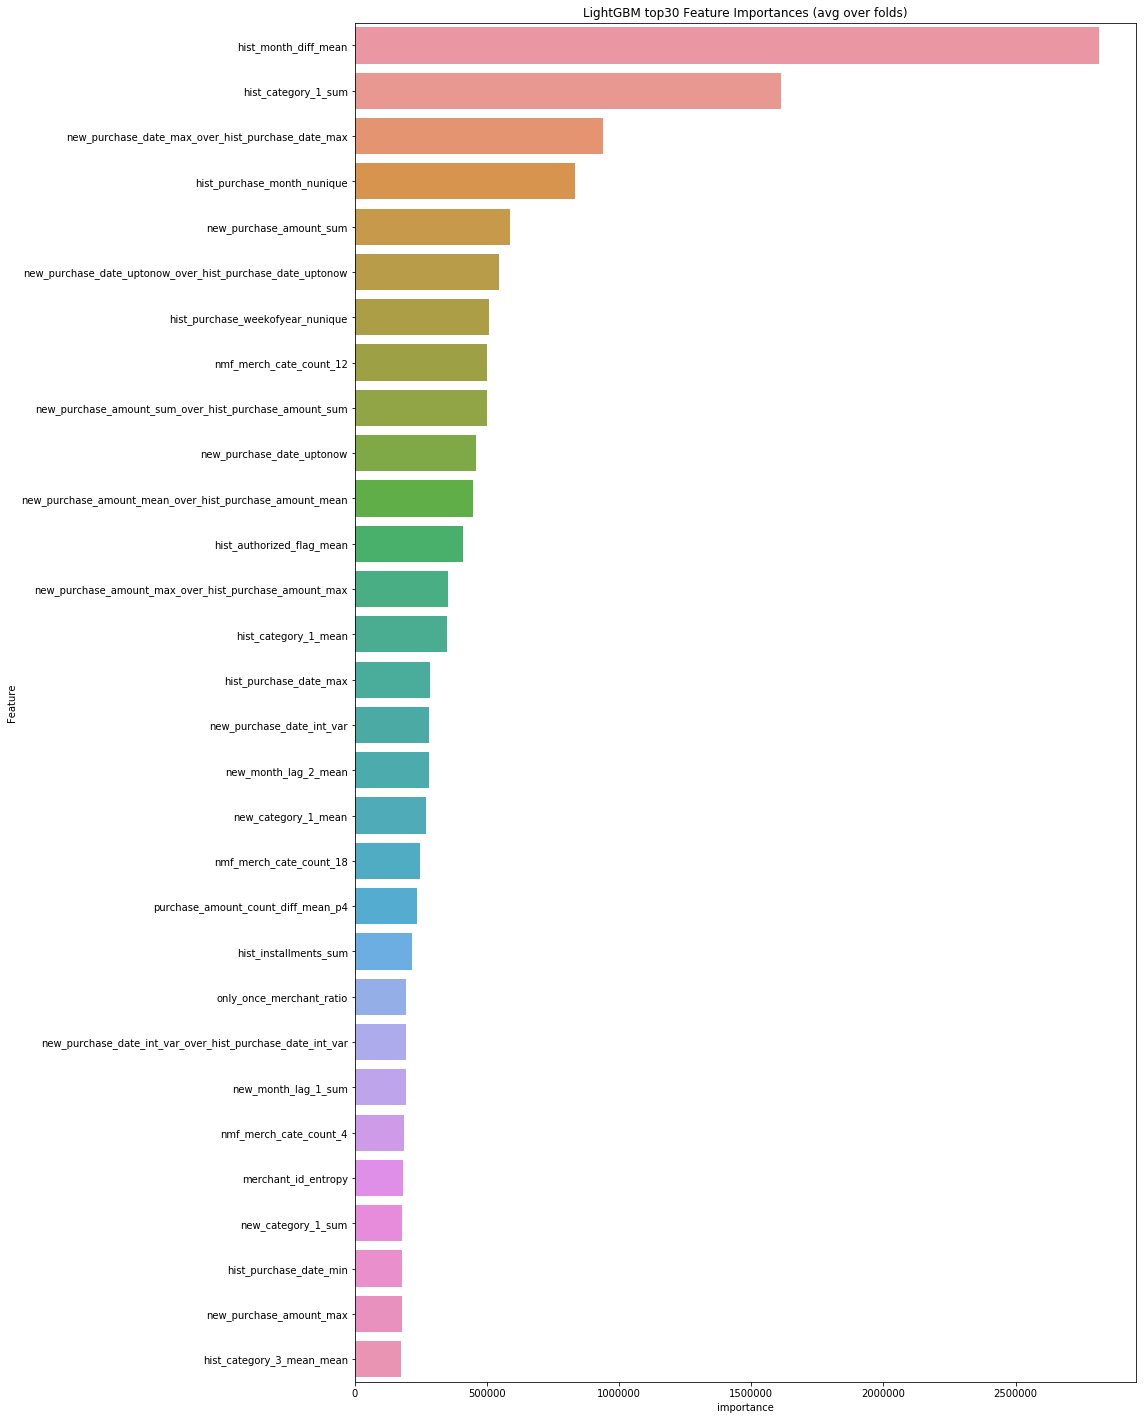

In [36]:
top_30_features = total_importance_df.sort_values(by='importance', ascending=False).head(30)
plt.figure(figsize=(14,25))
sns.barplot(x='importance', y='Feature', data=top_30_features)
plt.title('LightGBM top30 Feature Importances (avg over folds)')

In [37]:
sbm = pd.read_csv('./input/sample_submission.csv')
sbm["target"] = predictions_total
sbm.to_csv("./input/final_submission.csv", index=False)